In [198]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math

In [199]:
#Load the data from the downloaded file
tsla_df = pd.read_csv('TSLA.csv')

In [200]:
#Convert the date column to datetime
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
#Set the Date column as the index
tsla_df_indexed = tsla_df.set_index('Date')

In [201]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Set the number of days for the window
window = 20

#Run the simple_moving_average on the dataframe
tsla_df_indexed['SMA 20'] = simple_moving_average(tsla_df_indexed['Close'], window)

In [202]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

tsla_df_indexed['Upper Band'], tsla_df_indexed['Lower Band'] = create_bands(tsla_df_indexed['Close'], tsla_df_indexed['SMA 20'], 20)

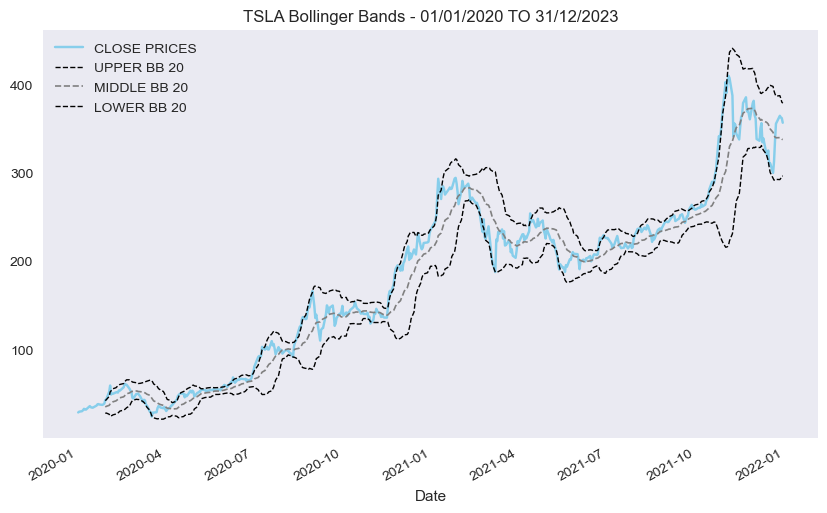

In [203]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("TSLA Bollinger Bands - 01/01/2020 TO 31/12/2023")
tsla_df_indexed['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [204]:
#Define a function to generate the trading signals
def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(tsla_df_indexed['Close'], tsla_df_indexed['Lower Band'], tsla_df_indexed['Upper Band'])

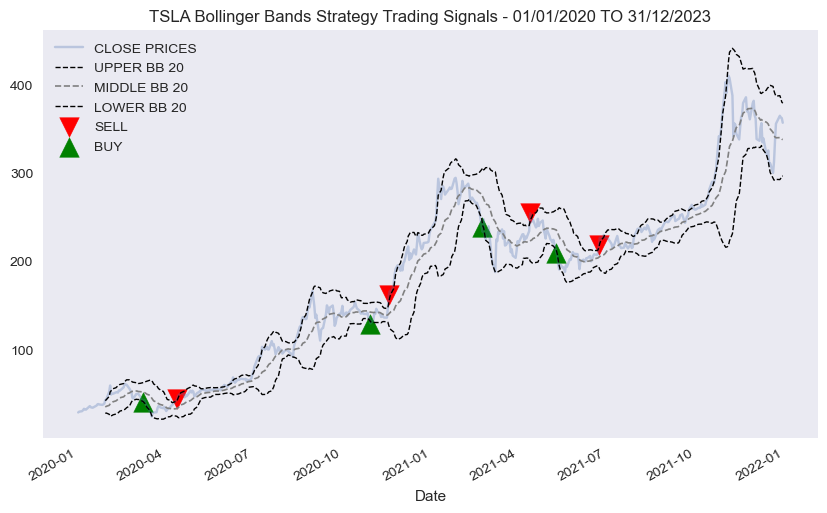

In [205]:
#Plot the figures with the trading signals
plt.figure(figsize = (10,6))
plt.title("TSLA Bollinger Bands Strategy Trading Signals - 01/01/2020 TO 31/12/2023")
tsla_df_indexed['Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(tsla_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(tsla_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [206]:
#Create positions for our strategy
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla_df_indexed['Close'])):
    if bands_signal[i] == 1:
        position[i] = 1
    elif bands_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [207]:
upper_bb = tsla_df_indexed['Upper Band']
lower_bb = tsla_df_indexed['Lower Band']
close_price = tsla_df_indexed['Close']
bands_signal = pd.DataFrame(bands_signal).rename(columns = {0:'Band Signals'}).set_index(tsla_df_indexed.index)
position = pd.DataFrame(position).rename(columns = {0:'Band Position'}).set_index(tsla_df_indexed.index)

frames = [close_price, upper_bb, lower_bb, bands_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

In [208]:
#Calculate the returns for the dataset
tsla_returns = pd.DataFrame(np.diff(tsla_df_indexed['Close'])).rename(columns = {0:'Returns'})
data_strategy = []

for i in range(len(tsla_returns)):
    try:
        returns = tsla_return['Returns'][i]*strategy['Band Position'][i]
        data_strategy.append(returns)
    except:
        pass

In [224]:
#Compute the cummulative returns from the returns dataset
bb_strategy_returns['Cummulative Returns'] = tsla_returns['Returns'].cumsum()
bb_strategy_returns['Cummulative Strategy'] = bb_strategy_return_df['Band Returns'].cumsum()

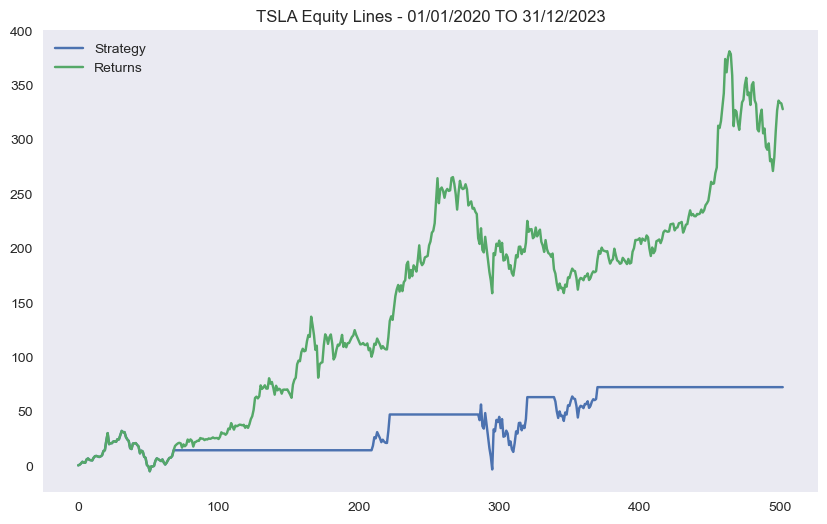

In [227]:
#Plot the figures with the trading signals
plt.figure(figsize = (10,6))
plt.title("TSLA Equity Lines - 01/01/2020 TO 31/12/2023")
plt.plot(bb_strategy_returns.index, bb_strategy_returns['Cummulative Strategy'], label = "Strategy")
plt.plot(bb_strategy_returns.index, bb_strategy_returns['Cummulative Returns'], label = "Returns")
plt.legend(loc='upper left')
plt.grid()
plt.show()